In [1]:
# Import the needed libraries 
## Attention:For the installation of Prophet please follow the instructions written here:  https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt


In [2]:
# Read in the given data and set the index column to the date column and parse the dates
df=pd.read_csv("../02_data_acquisition_understanding/01_data_source/sickness_table.csv", index_col="date", parse_dates=True ) 
df["drivers_atwork"]=df["n_duty"]+df["sby_need"]
df.index.freq="D" #Set the frequence to Daily
df.index

DatetimeIndex(['2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10',
               ...
               '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21',
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27'],
              dtype='datetime64[ns]', name='date', length=1152, freq='D')

In [3]:
# Prepare the Data for Prophet
# Create the column "date"
df["date"]=df.index
# Create new DataFrames with the column "date"
df_new=pd.DataFrame(df["date"])
# Create the column y="calls"
df_new["y"]=df["calls"]
# Delete the index
df_new.reset_index(drop=True, inplace=True)
# Rename the columns to the Prophet specifics
df_new.rename(columns={"date": "ds", "y": "y"}, inplace=True)
# Show the head of the DataFrame
df_new.head()

,ds,y
0,2016-04-01,8154.0
1,2016-04-02,8526.0
2,2016-04-03,8088.0
3,2016-04-04,7044.0
4,2016-04-05,7236.0


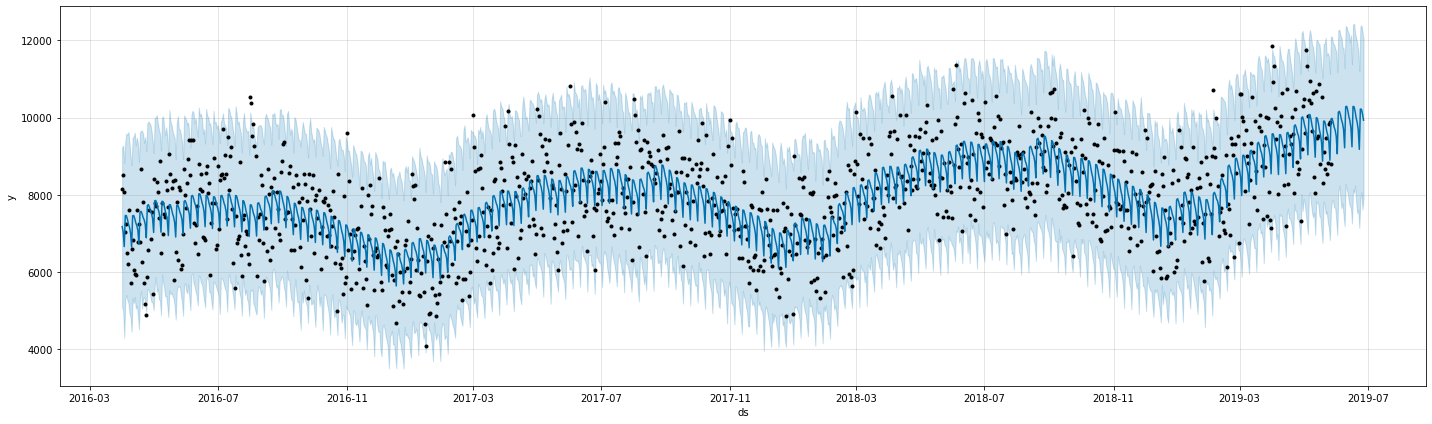

In [4]:
#Define the number of days the model should predict the workforce plan
numberofdaysforprediction=31

#Create the Prohpet-Model,with an interval_width of 95% (95% of the train values are in the predicted range) 
m = Prophet(interval_width=0.975, daily_seasonality=True,seasonality_mode="multiplicative")
# Train the Prophet-Model
m.fit(df_new)
# Create future datafame with xx days (periods & freq) as basis for prediction
future = m.make_future_dataframe(periods=numberofdaysforprediction,freq='D')
# Make predictions for the created future dataframe
forecast = m.predict(future)
#plot the predictions 
m.plot(forecast, figsize=(20, 6));
forecast.set_index(forecast["ds"], inplace=True)


In [5]:
# Generating the prdiction of drivers on duty and drivers on standby for the next 31 days
x_Value=4.82
df_predresult=pd.DataFrame(forecast["ds"].iloc[len(forecast)-numberofdaysforprediction:])
df_predresult["pred_n_duty"]=forecast["yhat"].iloc[len(forecast)-numberofdaysforprediction:]/x_Value
df_predresult["pred_n_sby"]=forecast["yhat_upper"].iloc[len(forecast)-numberofdaysforprediction:]/x_Value-forecast["yhat"].iloc[len(forecast)-numberofdaysforprediction:]/x_Value

#Round the values and cast to intger: 
df_predresult["pred_n_duty"]=df_predresult["pred_n_duty"].apply(lambda x: np.around(x))
df_predresult["pred_n_duty"]=df_predresult["pred_n_duty"].apply(lambda x: int(x))
df_predresult["pred_n_sby"]=df_predresult["pred_n_sby"].apply(lambda x: np.around(x))
df_predresult["pred_n_sby"]=df_predresult["pred_n_sby"].apply(lambda x: int(x))
#drop the column "ds" since the index is already the date 
df_predresult.drop("ds", inplace=True, axis=1)

In [6]:
# Show the predictions for the next 31 days
df_predresult

,pred_n_duty,pred_n_sby
ds,,
2019-05-28,2071,437
2019-05-29,2052,418
2019-05-30,2025,445
2019-05-31,2007,440
2019-06-01,1975,455
2019-06-02,1880,438
2019-06-03,2104,439
2019-06-04,2109,439
2019-06-05,2091,425


In [7]:
# Create an extract as csv --> the separator is a Semikolon and the decimals is a comma
df_predresult.to_csv("Workforceplaning.csv", decimal=",",sep=";")